## Семинар 5: "Улучшение сходимости нейросетей"

ФИО:

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import train_utils
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

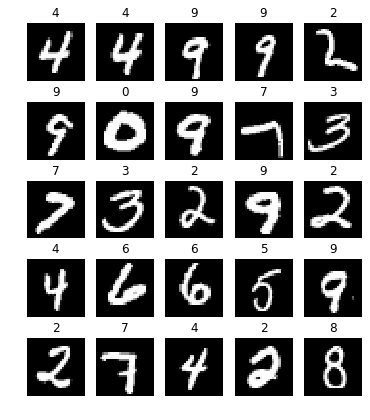

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

def new_linear_layer(input_size, output_size, mean=0, std=1):
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, mean, std)
    return layer
    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [7]:
##### YOUR CODE HERE #####
layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer(784, 500, mean=0, std=np.sqrt(2./500)))
layers.append(nn.ReLU())
for i in range(10):
    layers.append(new_linear_layer(500, 500, mean=0, std=np.sqrt(2./500)))
    layers.append(nn.ReLU())
layers.append(new_linear_layer(500, 10, mean=0, std=np.sqrt(2./10)))
layers.append(nn.LogSoftmax())
network = nn.Sequential(*layers)
network

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=500, bias=True)
  (3): ReLU()
  (4): Linear(in_features=500, out_features=500, bias=True)
  (5): ReLU()
  (6): Linear(in_features=500, out_features=500, bias=True)
  (7): ReLU()
  (8): Linear(in_features=500, out_features=500, bias=True)
  (9): ReLU()
  (10): Linear(in_features=500, out_features=500, bias=True)
  (11): ReLU()
  (12): Linear(in_features=500, out_features=500, bias=True)
  (13): ReLU()
  (14): Linear(in_features=500, out_features=500, bias=True)
  (15): ReLU()
  (16): Linear(in_features=500, out_features=500, bias=True)
  (17): ReLU()
  (18): Linear(in_features=500, out_features=500, bias=True)
  (19): ReLU()
  (20): Linear(in_features=500, out_features=500, bias=True)
  (21): ReLU()
  (22): Linear(in_features=500, out_features=10, bias=True)
  (23): LogSoftmax()
)

In [8]:
#пример:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.985187828540802
forward 1.069077730178833
forward 1.055011510848999
forward 1.041622519493103
forward 1.0297837257385254
forward 1.0120841264724731
forward 1.0499154329299927
forward 1.0406713485717773
forward 1.1155787706375122
forward 1.1038939952850342
forward 1.054581880569458
forward 0.9727192521095276
backward 0.2713422477245331
backward 0.22989431023597717
backward 0.2153806984424591
backward 0.19377213716506958
backward 0.18624012172222137
backward 0.16234955191612244
backward 0.15478946268558502
backward 0.13688454031944275
backward 0.12547548115253448
backward 0.1143723726272583
backward 0.09595649689435959
backward 0.08816386759281158


/Users/kosov/anaconda/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [9]:
##### YOUR CODE HERE #####

In [10]:
# Xavier

def xav_forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def xav_backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

def xav_init_layer(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    edge = np.sqrt(6) / np.sqrt(layer.in_features + layer.out_features)
    weight.uniform_(-edge, edge)

def xav_new_linear_layer(input_size, output_size):
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(xav_forward_hook)
    layer.register_backward_hook(xav_backward_hook)
    xav_init_layer(layer)
    return layer

In [11]:
layers = []
mean = 0
std = 0.1
layers.append(xav_new_linear_layer(784, 500))
layers.append(nn.Tanh())
for i in range(10):
    layers.append(xav_new_linear_layer(500, 500))
    layers.append(nn.Tanh())
layers.append(xav_new_linear_layer(500, 10))
layers.append(nn.LogSoftmax())
network = nn.Sequential(*layers)
network

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): Tanh()
  (2): Linear(in_features=500, out_features=500, bias=True)
  (3): Tanh()
  (4): Linear(in_features=500, out_features=500, bias=True)
  (5): Tanh()
  (6): Linear(in_features=500, out_features=500, bias=True)
  (7): Tanh()
  (8): Linear(in_features=500, out_features=500, bias=True)
  (9): Tanh()
  (10): Linear(in_features=500, out_features=500, bias=True)
  (11): Tanh()
  (12): Linear(in_features=500, out_features=500, bias=True)
  (13): Tanh()
  (14): Linear(in_features=500, out_features=500, bias=True)
  (15): Tanh()
  (16): Linear(in_features=500, out_features=500, bias=True)
  (17): Tanh()
  (18): Linear(in_features=500, out_features=500, bias=True)
  (19): Tanh()
  (20): Linear(in_features=500, out_features=500, bias=True)
  (21): Tanh()
  (22): Linear(in_features=500, out_features=10, bias=True)
  (23): LogSoftmax()
)

In [12]:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.985187828540802
forward 0.6510717868804932
forward 0.5000720024108887
forward 0.4177566468715668
forward 0.36842551827430725
forward 0.3293694853782654
forward 0.295938640832901
forward 0.2704469859600067
forward 0.25811633467674255
forward 0.24856328964233398
forward 0.23545534908771515
forward 0.22070780396461487
backward 0.02995845302939415
backward 0.00563449552282691
backward 0.005144218914210796
backward 0.0046735056675970554
backward 0.00430795643478632
backward 0.0040752156637609005
backward 0.003908902872353792
backward 0.0034671914763748646
backward 0.0030192427802830935
backward 0.002677959157153964
backward 0.002262561582028866
backward 0.001743076485581696


In [13]:
# He

def he_forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def he_backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

def he_init_layer(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=np.sqrt(2 / layer.out_features))

def he_new_linear_layer(input_size, output_size):
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(he_forward_hook)
    layer.register_backward_hook(he_backward_hook)
    he_init_layer(layer)
    return layer

In [14]:
layers = []
layers.append(he_new_linear_layer(784, 500))
layers.append(nn.ReLU())
for i in range(10):
    layers.append(he_new_linear_layer(500, 500))
    layers.append(nn.ReLU())
layers.append(he_new_linear_layer(500, 10))
layers.append(nn.LogSoftmax())
network = nn.Sequential(*layers)
network

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=500, bias=True)
  (3): ReLU()
  (4): Linear(in_features=500, out_features=500, bias=True)
  (5): ReLU()
  (6): Linear(in_features=500, out_features=500, bias=True)
  (7): ReLU()
  (8): Linear(in_features=500, out_features=500, bias=True)
  (9): ReLU()
  (10): Linear(in_features=500, out_features=500, bias=True)
  (11): ReLU()
  (12): Linear(in_features=500, out_features=500, bias=True)
  (13): ReLU()
  (14): Linear(in_features=500, out_features=500, bias=True)
  (15): ReLU()
  (16): Linear(in_features=500, out_features=500, bias=True)
  (17): ReLU()
  (18): Linear(in_features=500, out_features=500, bias=True)
  (19): ReLU()
  (20): Linear(in_features=500, out_features=500, bias=True)
  (21): ReLU()
  (22): Linear(in_features=500, out_features=10, bias=True)
  (23): LogSoftmax()
)

In [15]:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.985187828540802
forward 1.0402714014053345
forward 1.0343647003173828
forward 1.0507408380508423
forward 1.0503485202789307
forward 1.0453037023544312
forward 1.0845816135406494
forward 1.0554908514022827
forward 1.11505925655365
forward 1.0940027236938477
forward 1.0594260692596436
forward 1.0228163003921509
backward 0.2412707507610321
backward 0.21923522651195526
backward 0.18531493842601776
backward 0.1679307073354721
backward 0.1534096747636795
backward 0.13082943856716156
backward 0.11738812178373337
backward 0.11307501047849655
backward 0.10497093945741653
backward 0.10011428594589233
backward 0.08523669838905334
backward 0.07612582296133041


<i> 1.4 Сделайте выводы по первой части </i>

Видно, что дисперсии более-менее сохраняются <br>
Создается впечатление, что He для ReLU работает лучше, чем Xavier для Tanh

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [16]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5, mean=0, std=0.01):
        super(DropConnect, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim).normal_(mean=mean, std=std), requires_grad=True)
        self.bias = nn.Parameter(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.zeros(self.weight.shape)+(1-self.p)
            mask = torch.bernoulli(mask)
        else:
            mask = torch.ones(self.weight.shape)*self.p
        mask = Variable(mask, requires_grad=False)
        output = torch.mm(x, self.weight*mask)+self.bias
        return output

Epoch 9... (Train/Test) NLL: 0.122/0.090	Accuracy: 0.962/0.972

/Users/kosov/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


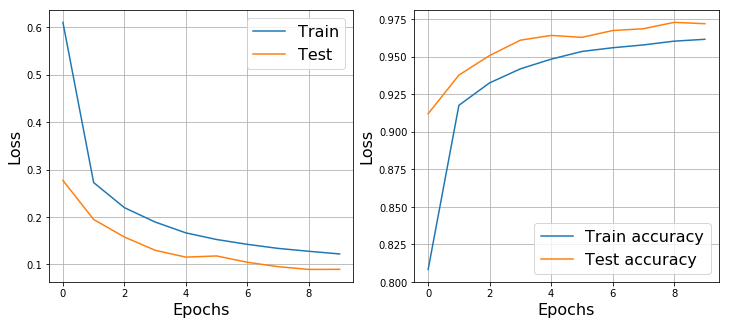

In [17]:
network = nn.Sequential(DropConnect(784, 100, p=0.5),
                        nn.ReLU(),
                        DropConnect(100, 100, p=0.5),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

train_utils.train(network, train_loader, test_loader, 10, 0.001, ravel_init=True)

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [ ]:
##### YOUR CODE HERE #####

Epoch 6... (Train/Test) NLL: 0.093/0.075	Accuracy: 0.970/0.975

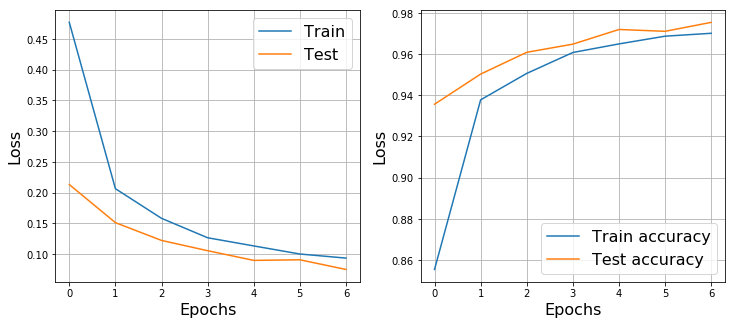

In [31]:
network = nn.Sequential(DropConnect(784, 200, p=0.5),
                        nn.ReLU(),
                        DropConnect(200, 200, p=0.5),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train_utils.train(network, train_loader, test_loader, 10, 0.001, ravel_init=True)

Epoch 9... (Train/Test) NLL: 0.236/0.092	Accuracy: 0.928/0.972

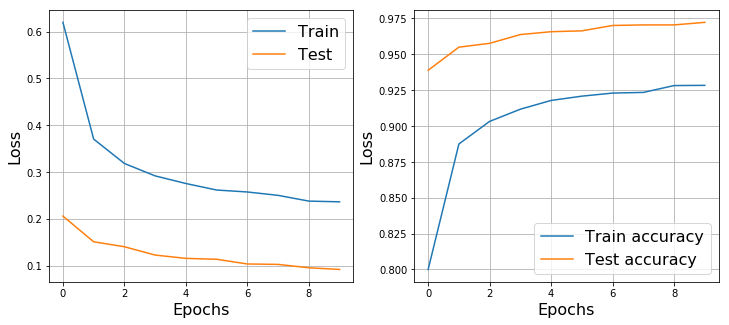

In [34]:
network = nn.Sequential(nn.Dropout(),
                        nn.Linear(784, 200),
                        nn.ReLU(),
                        nn.Dropout(),
                        nn.Linear(200, 200),
                        nn.ReLU(),
                        nn.Dropout(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train_utils.train(network, train_loader, test_loader, 10, 0.001, ravel_init=True)

<i> 2.3 Сделайте выводы по третьей части </i>

Подозрительно странный зазор в качестве между треином и тестом у сети с Dropout слоями, с чем это связано? 

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

Почему?

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [47]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x):
        output = (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-8)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [ ]:
##### YOUR CODE HERE #####

/Users/kosov/anaconda/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 9... (Train/Test) NLL: 0.072/0.069	Accuracy: 0.976/0.979

/Users/kosov/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


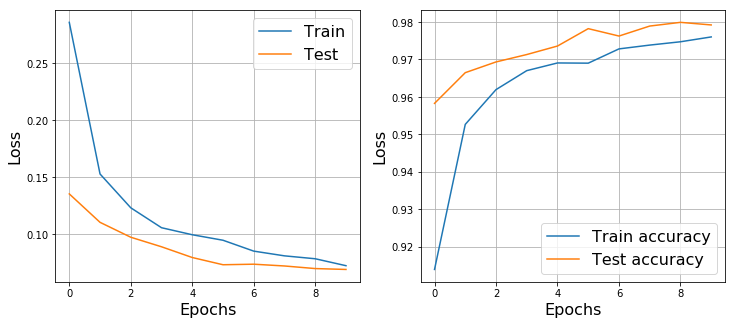

In [50]:
network = nn.Sequential(DropConnect(784, 200, p=0.5),
                        nn.ReLU(),
                        LayerNormalization(),
                        DropConnect(200, 200, p=0.5),
                        nn.ReLU(),
                        LayerNormalization(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train_utils.train(network, train_loader, test_loader, 10, 0.001, ravel_init=True)

/Users/kosov/anaconda/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 9... (Train/Test) NLL: 0.076/0.068	Accuracy: 0.975/0.979

/Users/kosov/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


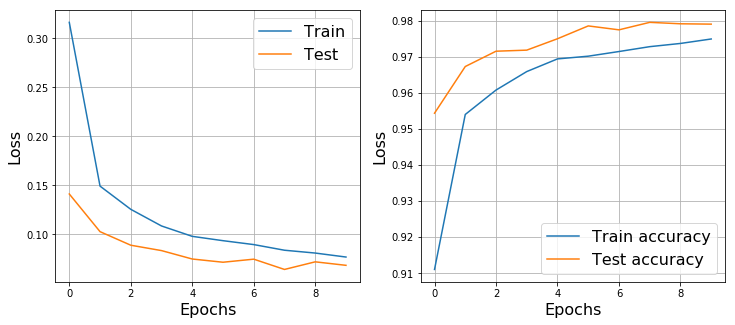

In [57]:
network = nn.Sequential(DropConnect(784, 200, p=0.5),
                        nn.ReLU(),
                        nn.BatchNorm1d(200),
                        DropConnect(200, 200, p=0.5),
                        nn.ReLU(),
                        nn.BatchNorm1d(200),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train_utils.train(network, train_loader, test_loader, 10, 0.001, ravel_init=True)

<i> 3.3 Сделайте выводы по третьей части </i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: